In [1]:
from share import *
import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.hed import HEDdetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/home/gridsan/qwang/.conda/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.


In [2]:
version = '24511719'
epoch = '4'
step = '112594'
city_dic={'chicago': 'Chicago', 'dallas':'Dallas', 'la':'Los Angeles'}

In [3]:
desc = {}
for c in ['chicago','la','dallas']:
    desc[c] = pd.read_csv("~/satellite_tiles_control/tile_descriptions/tile_descriptions_"+c+"_1114.csv").set_index(['xtile','ytile'])


In [4]:
model = create_model('./models/cldm_v15.yaml').cpu()
# model.load_state_dict(load_state_dict('./models/control_sd15_ini.ckpt', location='cuda'))
# model.load_state_dict(load_state_dict('./lightning_logs/version_23691853/checkpoints/epoch=8-step=74483.ckpt', location='cuda'))
# model.load_state_dict(load_state_dict('./lightning_logs/version_23745120/checkpoints/epoch=2-step=24494.ckpt', location='cuda:1'))
# model.load_state_dict(load_state_dict('./lightning_logs/version_23786778/checkpoints/epoch=12-step=106144.ckpt', location='cuda'))
# model.load_state_dict(load_state_dict('./lightning_logs/version_23786984/checkpoints/epoch=17-step=98531.ckpt', location='cuda'))
model.load_state_dict(load_state_dict('./lightning_logs/version_'+version+'/checkpoints/epoch='+epoch+'-step='+step+'.ckpt', location='cuda'))

model = model.cuda()
ddim_sampler = DDIMSampler(model)

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./lightning_logs/version_24511719/checkpoints/epoch=4-step=112594.ckpt]


In [5]:
import os
os.makedirs('./lightning_logs/version_'+version+'/image_log/', exist_ok=True)
os.makedirs('./lightning_logs/version_'+version+'/image_output/', exist_ok=True)

In [6]:
def process(x, y, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta):
    
    with torch.no_grad():
        input_image = cv2.imread("../satellite_tiles_control/satellite_tiles/"+str(zoom)+"/"+input_city+"/"+str(zoom)+"_"+str(x)+"_"+str(y)+".png")
        input_image = np.array(input_image)
        H,W,C = input_image.shape

        detected_map = cv2.imread("../satellite_tiles_control/skeleton/"+str(zoom)+"/"+input_city+"/"+str(x)+"/"+str(y)+".png", cv2.IMREAD_UNCHANGED)
        detected_map = np.array(detected_map)    

        # convert 4-channel source image to 3-channel
        #make mask of where the transparent bits are
        trans_mask = detected_map[:,:,3] == 0

        #replace areas of transparency with white and not transparent
        detected_map[trans_mask] = [255, 255, 255, 255]

        #new image without alpha channel...
        detected_map = cv2.cvtColor(detected_map, cv2.COLOR_BGRA2BGR)        
        #OpenCV read images in BGR order.
        control = cv2.cvtColor(detected_map, cv2.COLOR_BGR2RGB)
        control = torch.from_numpy(control.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)
            
        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)
            
        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [cv2.cvtColor(x_samples[i], cv2.COLOR_RGB2BGR) for i in range(num_samples)]
 

        return [detected_map] + [input_image] + results


# True vs. Gen

In [7]:
zoom = "16"
num_samples = 1
image_resolution = 512
strength = 1.0
guess_mode = False
detect_resolution = 512
ddim_steps = 20
scale = 9.0
seed = 5354
eta = 0.0
a_prompt = 'best quality, extremely detailed'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'

In [8]:
input_city = 'chicago'
output_city = 'chicago'

xtile = '16814'
ytile = '24363'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_skeleton.png',outputs[0]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_true.png',outputs[1]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen.png',outputs[2]);

print(prompt)

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Satellite image of a city in Chicago. Landuse parcels include 40 percent residential, 15 percent industrial, 15 percent commercial, 10 percent park, 5 percent open parking. Residential area consists entirely of houses. Medium building coverage. 


In [9]:
input_city = 'dallas'
output_city = 'dallas'

xtile = '15168'
ytile = '26380'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_skeleton.png',outputs[0]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_true.png',outputs[1]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen.png',outputs[2]);

print(prompt)

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Satellite image of a town in Dallas. Landuse parcels include 30 percent residential, 25 percent industrial, 20 percent commercial, 20 percent farmland. Residential area consists entirely of houses. Medium building coverage. 


In [10]:
input_city = 'la'
output_city = 'la'

xtile = '11317'
ytile = '26249'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_skeleton.png',outputs[0]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_true.png',outputs[1]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen.png',outputs[2]);

print(prompt)

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Satellite image of a town in Los Angeles. Landuse parcels include 65 percent residential, 20 percent park. Residential area has a mix of apartments and houses. Medium building coverage. 


# Land use understanding

In [11]:
input_city = 'chicago'
output_city = 'chicago'

xtile = '16814'
ytile = '24363'

prompt = "Satellite image of a city in Chicago. Landuse parcels include 60 percent residential, 20 percent park. Medium building coverage. "
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_land0.png',outputs[2]);

prompt = "Satellite image of a city in Chicago. Landuse parcels include 60 percent commercial, 20 percent open parking. Medium building coverage. "
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_land1.png',outputs[2]);

prompt = "Satellite image of a city in Chicago. Landuse parcels include 30 percent industrial, 25 percent nature reserve, 25 percent farmland. Medium building coverage. "
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_land2.png',outputs[2]);

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


In [12]:
input_city = 'dallas'
output_city = 'dallas'

xtile = '15168'
ytile = '26380'

prompt = "Satellite image of a town in Dallas. Landuse parcels include 60 percent residential, 20 percent park. Medium building coverage."
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_land0.png',outputs[2]);

prompt = "Satellite image of a town in Dallas. Landuse parcels include 60 percent commercial, 20 percent open parking. Medium building coverage. "
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_land1.png',outputs[2]);

prompt = "Satellite image of a town in Dallas. Landuse parcels include 30 percent industrial, 25 percent nature reserve, 25 percent farmland. Medium building coverage. "
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_land2.png',outputs[2]);

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


In [13]:
input_city = 'la'
output_city = 'la'

xtile = '11317'
ytile = '26249'

prompt = "Satellite image of a town in Los Angeles. Landuse parcels include 60 percent residential, 20 percent park. Medium building coverage."
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_land0.png',outputs[2]);

prompt = "Satellite image of a town in Los Angeles. Landuse parcels include 60 percent commercial, 20 percent open parking. Medium building coverage. "
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_land1.png',outputs[2]);

prompt = "Satellite image of a town in Los Angeles. Landuse parcels include 30 percent industrial, 25 percent nature reserve, 25 percent farmland. Medium building coverage. "
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_land2.png',outputs[2]);

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


# Design Creativity

In [14]:
input_city = 'chicago'
output_city = 'chicago'

xtile = '16814'
ytile = '24363'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 123, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen1.png',outputs[2]);
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 321, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen2.png',outputs[2]);
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 555, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen3.png',outputs[2]);

print(prompt)

Global seed set to 123


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 321


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Satellite image of a city in Chicago. Landuse parcels include 40 percent residential, 15 percent industrial, 15 percent commercial, 10 percent park, 5 percent open parking. Residential area consists entirely of houses. Medium building coverage. 


In [15]:
input_city = 'la'
output_city = 'la'

xtile = '11317'
ytile = '26249'


prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 123, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen1.png',outputs[2]);
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 321, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen2.png',outputs[2]);
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 555, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen3.png',outputs[2]);

print(prompt)

Global seed set to 123


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 321


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Satellite image of a town in Los Angeles. Landuse parcels include 65 percent residential, 20 percent park. Residential area has a mix of apartments and houses. Medium building coverage. 


In [16]:
input_city = 'dallas'
output_city = 'dallas'

xtile = '15168'
ytile = '26380'


prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 123, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen1.png',outputs[2]);
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 321, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen2.png',outputs[2]);
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 555, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen3.png',outputs[2]);

print(prompt)

Global seed set to 123


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 321


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Satellite image of a town in Dallas. Landuse parcels include 30 percent residential, 25 percent industrial, 20 percent commercial, 20 percent farmland. Residential area consists entirely of houses. Medium building coverage. 


# Design Constraints

In [17]:
input_city = 'chicago'
output_city = 'chicago'

xtile = '16816'
ytile = '24359'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen.png',outputs[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_skeleton.png',outputs[0]);

print(prompt)


# xtile = '16809'
# ytile = '24365'

# prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']

# outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
# cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen.png',outputs[2]);
# cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_skeleton.png',outputs[0]);


# print(prompt)

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Satellite image of a city in Chicago. Landuse parcels include 20 percent residential, 20 percent commercial, 40 percent park. Residential area consists entirely of apartments. Dense building coverage. 


In [18]:
input_city = 'la'
output_city = 'la'

xtile = '11245'
ytile = '26178'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen.png',outputs[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_skeleton.png',outputs[0]);

print(prompt)

xtile = '11223'
ytile = '26142'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_gen.png',outputs[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_skeleton.png',outputs[0]);

print(prompt)

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Satellite image of a town in Los Angeles. Landuse parcels include 100 percent industrial. Dense building coverage. 
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Satellite image of a town in Los Angeles. Landuse parcels include 65 percent residential, 25 percent commercial. Residential area consists entirely of houses. Dense building coverage. 


# City textures

In [19]:
input_city = 'chicago'
output_city = 'dallas'

xtile = '16814'
ytile = '24363'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']
prompt = prompt.replace(city_dic[input_city], city_dic[output_city])

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_'+output_city+'.png',outputs[2]);

print(prompt)

input_city = 'chicago'
output_city = 'la'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']
prompt = prompt.replace(city_dic[input_city], city_dic[output_city])

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 123, eta)

cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_'+output_city+'.png',outputs[2]);

print(prompt)

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
Global seed set to 123


Satellite image of a city in Dallas. Landuse parcels include 40 percent residential, 15 percent industrial, 15 percent commercial, 10 percent park, 5 percent open parking. Residential area consists entirely of houses. Medium building coverage. 
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Satellite image of a city in Los Angeles. Landuse parcels include 40 percent residential, 15 percent industrial, 15 percent commercial, 10 percent park, 5 percent open parking. Residential area consists entirely of houses. Medium building coverage. 


In [20]:
input_city = 'dallas'
output_city = 'chicago'

xtile = '15168'
ytile = '26380'


prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']
prompt = prompt.replace(city_dic[input_city], city_dic[output_city])

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_'+output_city+'.png',outputs[2]);

print(prompt)

input_city = 'dallas'
output_city = 'la'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']
prompt = prompt.replace(city_dic[input_city], city_dic[output_city])

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_'+output_city+'.png',outputs[2]);

print(prompt)

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
Global seed set to 5354


Satellite image of a town in Chicago. Landuse parcels include 30 percent residential, 25 percent industrial, 20 percent commercial, 20 percent farmland. Residential area consists entirely of houses. Medium building coverage. 
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Satellite image of a town in Los Angeles. Landuse parcels include 30 percent residential, 25 percent industrial, 20 percent commercial, 20 percent farmland. Residential area consists entirely of houses. Medium building coverage. 


In [21]:
input_city = 'la'
output_city = 'chicago'

xtile = '11317'
ytile = '26249'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']
prompt = prompt.replace(city_dic[input_city], city_dic[output_city])

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_'+output_city+'.png',outputs[2]);

print(prompt)

input_city = 'la'
output_city = 'dallas'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']
prompt = prompt.replace(city_dic[input_city], city_dic[output_city])

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_'+output_city+'.png',outputs[2]);

print(prompt)

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
Global seed set to 5354


Satellite image of a town in Chicago. Landuse parcels include 65 percent residential, 20 percent park. Residential area has a mix of apartments and houses. Medium building coverage. 
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Satellite image of a town in Dallas. Landuse parcels include 65 percent residential, 20 percent park. Residential area has a mix of apartments and houses. Medium building coverage. 


In [22]:
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/'+input_city+'_'+xtile+'_'+ytile+'_'+output_city+'_test.png',outputs[1]);


# Ablation Study

In [23]:
seed = 456

In [24]:
# A random tile where hint image is blank
xtile = '16739'
ytile = '24359'
zoom = "16"
input_city = 'chicago'
output_city = 'chicago'

prompt = "Satellite image of a city in Chicago. Landuse parcels include 40 precent residential, 20 percent commercial, 20 percent park. Sparse building coverage."

In [25]:
# city/town
prompt1 = prompt.replace("town", "city")
prompt2 = prompt.replace("city", "town")
outputs1 = process(xtile, ytile, zoom, input_city, output_city, prompt1, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
outputs2 = process(xtile, ytile, zoom, input_city, output_city, prompt2, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

cv2.imwrite('./lightning_logs/version_'+version+'/image_output/ab_'+input_city+'_'+xtile+'_'+ytile+'_1city.png',outputs1[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/ab_'+input_city+'_'+xtile+'_'+ytile+'_1town.png',outputs2[2]);
print(prompt1, prompt2)

Global seed set to 456


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
Global seed set to 456


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Satellite image of a city in Chicago. Landuse parcels include 40 precent residential, 20 percent commercial, 20 percent park. Sparse building coverage. Satellite image of a town in Chicago. Landuse parcels include 40 precent residential, 20 percent commercial, 20 percent park. Sparse building coverage.


In [26]:
# house/apartment
prompt1 = '.'.join(prompt.split('.')[:2] + [' Residential area consists entirely of houses'] + prompt.split('.')[-2:])
prompt2 = '.'.join(prompt.split('.')[:2] + [' Residential area consists entirely of apartments'] + prompt.split('.')[-2:])
prompt3 = '.'.join(prompt.split('.')[:2] + [' Residential area has a mix of apartments and houses'] + prompt.split('.')[-2:])

outputs1 = process(xtile, ytile, zoom, input_city, output_city, prompt1, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
outputs2 = process(xtile, ytile, zoom, input_city, output_city, prompt2, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
outputs3 = process(xtile, ytile, zoom, input_city, output_city, prompt3, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

cv2.imwrite('./lightning_logs/version_'+version+'/image_output/ab_'+input_city+'_'+xtile+'_'+ytile+'_2house.png',outputs1[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/ab_'+input_city+'_'+xtile+'_'+ytile+'_2apartments.png',outputs2[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/ab_'+input_city+'_'+xtile+'_'+ytile+'_2mix.png',outputs3[2]);

Global seed set to 456


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
Global seed set to 456


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
Global seed set to 456


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


In [27]:
prompt1 = '.'.join(prompt.split('.')[:-2] + [' Sparse building coverage.']) 
prompt2 = '.'.join(prompt.split('.')[:-2] + [' Medium building coverage.'])
prompt3 = '.'.join(prompt.split('.')[:-2] + [' Dense building coverage.'])

outputs1 = process(xtile, ytile, zoom, input_city, output_city, prompt1, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
outputs2 = process(xtile, ytile, zoom, input_city, output_city, prompt2, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
outputs3 = process(xtile, ytile, zoom, input_city, output_city, prompt3, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

cv2.imwrite('./lightning_logs/version_'+version+'/image_output/ab_'+input_city+'_'+xtile+'_'+ytile+'_3low_building.png',outputs1[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/ab_'+input_city+'_'+xtile+'_'+ytile+'_3med_building.png',outputs2[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_output/ab_'+input_city+'_'+xtile+'_'+ytile+'_3high_building.png',outputs3[2]);

Global seed set to 456


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 456


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 456


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


# Generation Results (Random Sample; Generated vs True)

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


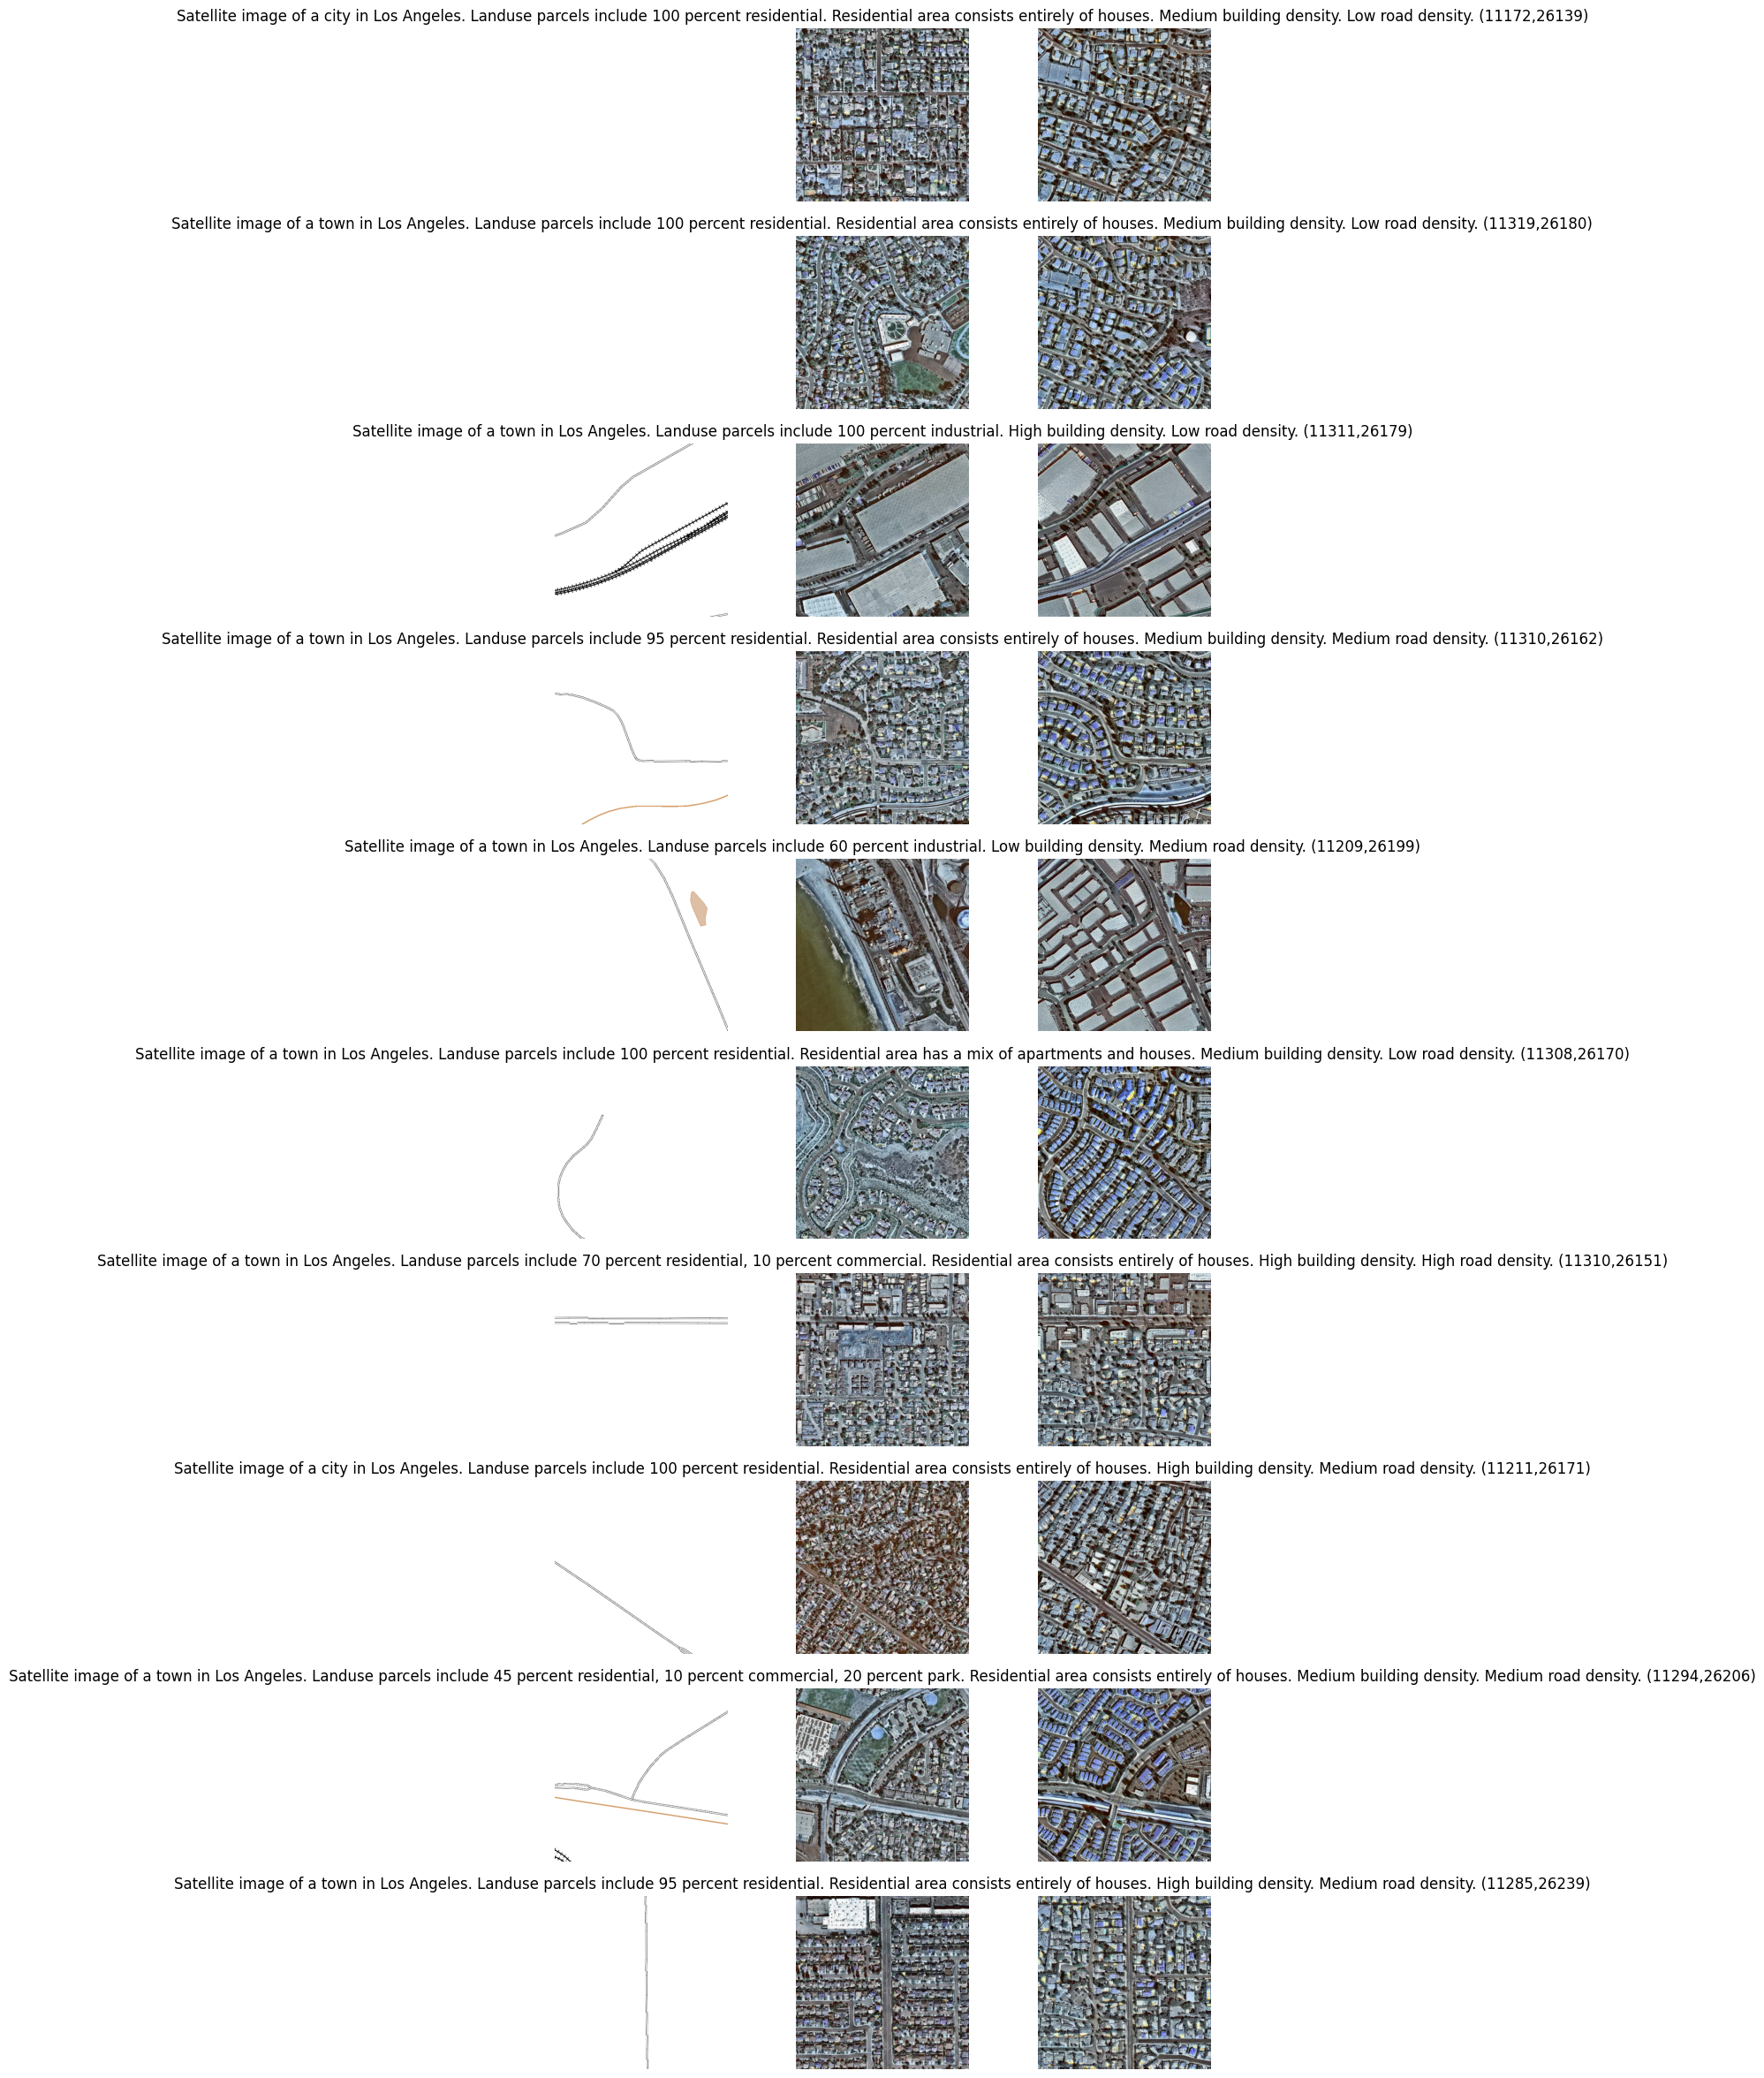

In [28]:
import os
os.makedirs('./lightning_logs/version_'+version+'/image_log/', exist_ok=True)

tile_descriptions = pd.read_csv("~/satellite_tiles_control/tile_descriptions/tile_descriptions_la_1103.csv")
tile_descriptions = tile_descriptions.sample(10, random_state=62)
                                
fig, ax = plt.subplots(10, 3, figsize=(10, 30))
i = 0

for xtile, ytile, city, prompt in zip(tile_descriptions['xtile'], tile_descriptions['ytile'], tile_descriptions['city'], tile_descriptions['final_description']):
    
    xtile = str(xtile)
    ytile = str(ytile)
    zoom = "16"
    input_city = city
    output_city = city

    num_samples = 1
    image_resolution = 512
    strength = 1.0
    guess_mode = False
    detect_resolution = 512
    ddim_steps = 20
    scale = 9.0
    seed = 5354
    eta = 0.0
    a_prompt = 'best quality, extremely detailed'
    n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'

    outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

    
    if input_city != output_city:
        prompt = prompt.replace(city_dic[input_city], city_dic[output_city])
        outputs_1 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

    ax[i,0].imshow(outputs[0])
    ax[i,0].axis('off')
    if input_city == output_city:
        ax[i,1].imshow(outputs[1])
    else:
        ax[i,1].imshow(outputs_1[2])
    ax[i,1].axis('off')
    ax[i,2].imshow(outputs[2])
    ax[i,2].axis('off')
    if input_city != output_city:
        prompt = prompt.replace(city_dic[input_city], 'X')
    ax[i,1].set_title(prompt+" ("+xtile+","+ytile+")")
    
    i += 1
    
fig.savefig('./lightning_logs/version_'+version+'/image_log/'+epoch+"-"+step+"_"+input_city+"_"+output_city+".png", bbox_inches='tight')